In [537]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 

# input some data of interest 
path = '~/NCAA'

tour_seed = pd.read_csv(path + "/NCAATourneySeeds.csv") # 1985-2018
tour_comp_result = pd.read_csv(path + "/NCAATourneyCompactResults.csv") # 1985-2017
reg_detailed_result = pd.read_csv(path + "/RegularSeasonDetailedResults.csv") # 2003-2018
reg_comp_result = pd.read_csv(path + "/RegularSeasonCompactResults.csv") # 1985-2018
#sub1 = pd.read_csv(path + "/SampleSubmissionStage1.csv") # 2014-2017
sub2 = pd.read_csv(path + "/SampleSubmissionStage2.csv") # 2018
coaches = pd.read_csv(path + "/TeamCoaches.csv") # 1985-2018

###  How often do team enter Division Tournament for all team entered 2018? 

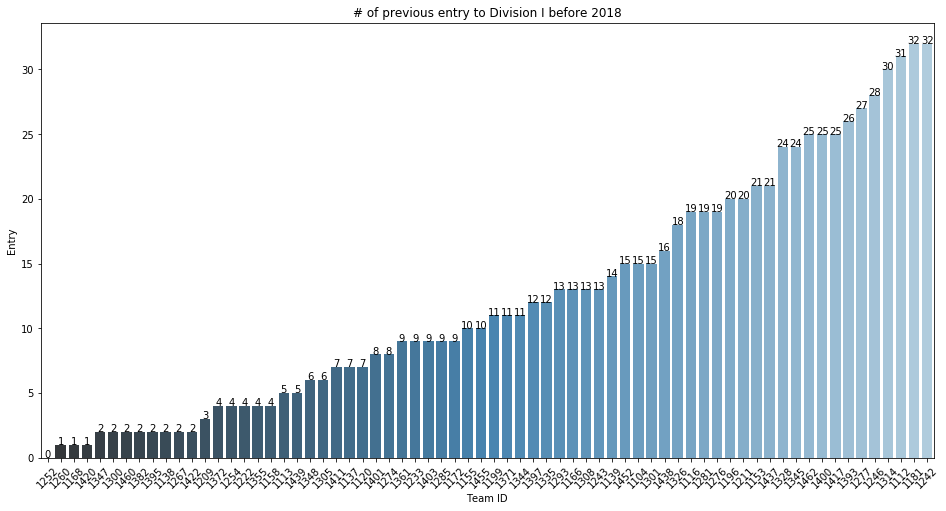

count    68.000000
mean     12.294118
std       9.073594
min       0.000000
25%       4.000000
50%      10.500000
75%      19.000000
max      32.000000
Name: Entry, dtype: float64


In [542]:
df_entry = pd.merge(tour_seed.loc[tour_seed.Season < 2018], tour_seed[tour_seed.Season == 2018], how="right", on="TeamID")
df_entry = df_entry.groupby("TeamID", as_index=False).aggregate({"Season_x": "count"})
df_entry.rename({"Season_x": "Entry"}, axis="columns", inplace=True)
df_entry.sort_values(by="Entry", inplace=True)
df_entry.reset_index(drop=True, inplace=True)

plt.figure(figsize=(16,8))
ax = sns.barplot(df_entry.index, "Entry", data=df_entry, palette="Blues_d")
ax.set_xticklabels(labels=df_entry.TeamID, rotation=45)
for p, entry in zip(ax.patches, df_entry.Entry):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, 
           height,
           entry,
           ha = "center")
plt.xlabel("Team ID")
plt.title("# of previous entry to Division I before 2018")
plt.show()

print(df_entry.Entry.describe())

**Findings**: 
+ For the past 34 seasons (1985-2018), more than half of the team that entered Division I League in 2018 has achieved this for more than 10 times, 25% of team has achieved more than 19 times. This means most of the strong team remain competetive all the time, which make sense in sports as excellent players tend to group for better achievement.

### How do coaches' life-time regular/tournament winning rate look like?

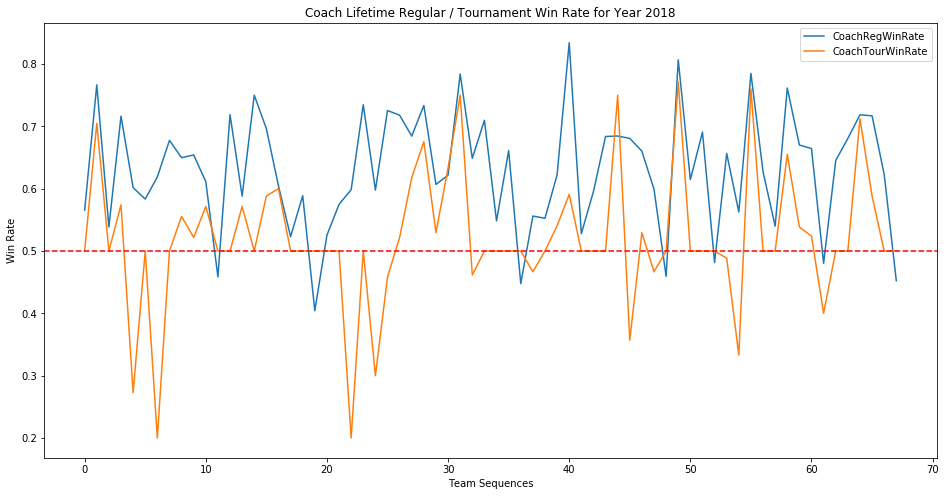

In [545]:
def coach_reg_win_rate(season):
    """ 
    season: INT
        Represents season to be predicted. 
    return: DataFrame with 'TeamID' and 'CoachRegWinRate' as columns
    """
    df_reg_win = pd.merge(reg_comp_result[reg_comp_result.Season <= season], 
                          coaches, how="inner", left_on=["Season", "WTeamID"], right_on=["Season","TeamID"])
    df_reg_lose = pd.merge(reg_comp_result[reg_comp_result.Season <= season], 
                           coaches, how="inner", left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"])
    
    reg_win_num = df_reg_win.groupby("CoachName", as_index=False).aggregate({"Season":"count"})
    reg_win_num.rename({"Season":"NumWins"}, axis="columns", inplace=True)
    reg_lose_num = df_reg_lose.groupby("CoachName", as_index=False).aggregate({"Season":"count"})
    reg_lose_num.rename({"Season":"NumLoses"}, axis="columns", inplace=True)
    
    reg_concat = pd.merge(reg_win_num, reg_lose_num, how="inner", on="CoachName")
    reg_concat["CoachRegWinRate"] = reg_concat.NumWins / (reg_concat.NumWins + reg_concat.NumLoses)

    tour_coaches = pd.merge(tour_seed[tour_seed.Season==season],
                            coaches[coaches["LastDayNum"]==154],
                            left_on=["Season", "TeamID"], 
                            right_on=["Season", "TeamID"])
    
    reg_coaches_win_rate = reg_concat.merge(tour_coaches, on="CoachName")
    return reg_coaches_win_rate.loc[:, ["Season", "TeamID", "CoachRegWinRate"]]
    

def coach_tour_win_rate(season):
    """
    This is actually all tour win rate before current year that need to be predicted.
    
    season: INT
        Represents season to be predicted
    return: DataFrame with 'TeamID' and 'CoachTourWinRate' as columns
    """
    df_tour_win = pd.merge(tour_comp_result.loc[tour_comp_result["Season"] < season], 
                           coaches, how="inner", 
                           left_on=["Season", "WTeamID"], 
                           right_on=["Season","TeamID"])
    df_tour_lose = pd.merge(tour_comp_result.loc[tour_comp_result["Season"] < season], 
                            coaches, how="inner", 
                            left_on=["Season", "LTeamID"], 
                            right_on=["Season", "TeamID"])

    tour_win_num = df_tour_win.groupby("CoachName", as_index=False).aggregate({"Season":"count"})
    tour_win_num.rename({"Season":"NumWins"}, axis="columns", inplace=True)
    tour_lose_num = df_tour_lose.groupby("CoachName", as_index=False).aggregate({"Season":"count"})
    tour_lose_num.rename({"Season":"NumLoses"}, axis="columns", inplace=True)
    tour_concat = pd.merge(tour_win_num, tour_lose_num, how="inner", on="CoachName")
    tour_concat["CoachTourWinRate"] = tour_concat.NumWins / (tour_concat.NumWins + tour_concat.NumLoses)
    
    tour_coaches = pd.merge(tour_seed[tour_seed.Season==season],
                            coaches[coaches["LastDayNum"]==154], 
                            left_on=["Season", "TeamID"], 
                            right_on=["Season", "TeamID"])
    
    tour_coaches_win_rate = tour_concat.merge(tour_coaches,how="right", on="CoachName")
   
    # when coaches has not tournament data, fill winning rate with 0.5 as non-informative guess
    tour_coaches_win_rate.fillna(value=0.5, inplace=True) 
    return tour_coaches_win_rate.loc[:, ["Season", "TeamID", "CoachTourWinRate"]]

reg2018 = coach_reg_win_rate(2018)
tour2018 = coach_tour_win_rate(2018)
rate2018 = reg2018.merge(tour2018, on="TeamID")

plt.figure(figsize=(16,8))
plt.plot(rate2018.CoachRegWinRate)
plt.plot(rate2018.CoachTourWinRate)
plt.legend()
plt.axhline(y=0.5, color='r', linestyle='--')
plt.xlabel("Team Sequences")
plt.ylabel("Win Rate")
plt.title("Coach Lifetime Regular / Tournament Win Rate for Year 2018")
plt.show()

**Findings**: 
+ Most of time, coaches with high regular season winning rate are accompanied by high tournament winning rate, which probably indicate regular season winning rate could be good feature for predicting tournament result.
+ Some extreme case still exist, coaches who have relatively high regular season winning end up with much lower winning rate in tournament. I suppose this is why this tournament is call **March Madness**...